In [52]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
import glob
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
'''import nltk
nltk.download('stopwords')'''



"import nltk\nnltk.download('stopwords')"

In [53]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [54]:
filenames = list(glob.glob("data/*"))
dataframes = [pd.read_csv(file) for file in filenames]

In [55]:
metadata = pd.concat(dataframes)
metadata.head(10)

,projectname,classification,commenttext
0,apache-ant-1.7.0,DEFECT,// FIXME formatters are not thread-safe
1,apache-ant-1.7.0,DEFECT,"// XXX: (Jon Skeet) The comment ""if it hasn't been done already"" may // not be strictly true. wrapper.maybeConfigure() won't configure the same // attributes/text more than once, but it may well add the children again, // unless I've missed something."
2,apache-ant-1.7.0,DEFECT,"// I hate to admit it, but we don't know what happened // here. Throw the Exception."
3,apache-ant-1.7.0,DEFECT,"// Just a note: StarTeam has a status for NEW which implies // that there is an item on your local machine that is not // in the repository. These are the items that show up as // NOT IN VIEW in the Starteam GUI. // One would think that we would want to perhaps checkin the // NEW items (not in all cases! - Steve Cohen 15 Dec 2001) // Unfortunately, the sdk doesn't really work, and we can't // actually see anything with a status of NEW. That is why // we can just check out everything here without worrying // about losing anything."
4,apache-ant-1.7.0,DEFECT,// the generated classes must not be added in the generic JAR! // is that buggy on old JOnAS (2.4) ??
5,apache-ant-1.7.0,DEFECT,// todo: is this comment still relevant ?? // FIXME: need to use a SAXSource as the source for the transform // so we can plug in our own entity resolver
6,apache-ant-1.7.0,DEFECT,"// This is turned off temporarily. There appears to be a bug // in SelectorUtils.matchPattern() where it is recursive on // Windows even if no ** is in pattern. //assertEquals(""FFFTFFFFFFFF"", results); // Unix // vs //assertEquals(""FFFTFFFFTFFF"", results); // Windows"
7,apache-ant-1.7.0,DEFECT,// pattern now holds ** while string is not exhausted // this will generate false positives but we can live with that.
8,apache-ant-1.7.0,DEFECT,"// FIXME: Is ""No Namespace is Empty Namespace"" really OK?"
9,apache-ant-1.7.0,DEFECT,// FIXME this is actually not very cpu cycles friendly as we are converting from // dos to java while the underlying Sun implementation will convert // from java to dos time for internal storage...


In [56]:
#Form labels for SATD: 0 for non-satd and 1 for satd
# Is important that text labels are converted into numeric for NN
metadata['label'] = np.where(metadata.classification == 'WITHOUT_CLASSIFICATION', 0, 1)
metadata.head()

,projectname,classification,commenttext,label
0,apache-ant-1.7.0,DEFECT,// FIXME formatters are not thread-safe,1
1,apache-ant-1.7.0,DEFECT,"// XXX: (Jon Skeet) The comment ""if it hasn't been done already"" may // not be strictly true. wrapper.maybeConfigure() won't configure the same // attributes/text more than once, but it may well add the children again, // unless I've missed something.",1
2,apache-ant-1.7.0,DEFECT,"// I hate to admit it, but we don't know what happened // here. Throw the Exception.",1
3,apache-ant-1.7.0,DEFECT,"// Just a note: StarTeam has a status for NEW which implies // that there is an item on your local machine that is not // in the repository. These are the items that show up as // NOT IN VIEW in the Starteam GUI. // One would think that we would want to perhaps checkin the // NEW items (not in all cases! - Steve Cohen 15 Dec 2001) // Unfortunately, the sdk doesn't really work, and we can't // actually see anything with a status of NEW. That is why // we can just check out everything here without worrying // about losing anything.",1
4,apache-ant-1.7.0,DEFECT,// the generated classes must not be added in the generic JAR! // is that buggy on old JOnAS (2.4) ??,1


In [57]:
print(metadata['label'].value_counts())

0    58204
1     4071
Name: label, dtype: int64


In [58]:
print(metadata.projectname.unique())

['apache-ant-1.7.0' 'apache-jmeter-2.10' 'argouml' 'columba-1.4-src'
 'emf-2.4.1' 'hibernate-distribution-3.3.2.GA' 'jEdit-4.2'
 'jfreechart-1.0.19' 'jruby-1.4.0' 'sql12']


In [59]:
#Specify in project dataset name to test
df = metadata[metadata.projectname == 'argouml']
print(df.isnull().sum())
df.info()

projectname       0
classification    0
commenttext       0
label             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9452 entries, 0 to 9451
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   projectname     9452 non-null   object
 1   classification  9452 non-null   object
 2   commenttext     9452 non-null   object
 3   label           9452 non-null   int32 
dtypes: int32(1), object(3)
memory usage: 332.3+ KB


In [60]:
df[0:5]

,projectname,classification,commenttext,label
0,argouml,DEFECT,"// TODO: This brute force approach of updating listeners on each // and every event, without checking the event type or any other // information is going to cause lots of InvalidElementExceptions // in subclasses implementations of updateListeners (and they // won't have the event information to make their own decisions)",1
1,argouml,DEFECT,/* TODO: The above statement also refreshes when \r * we are not shown (to be verified) - hence \r * not entirely correct. */,1
2,argouml,DEFECT,"/**\r * Class to display graphics for a UML SynchState in a diagram. <p>\r * \r * TODO: If the font increases, the circle should grow, too.\r *\r * @author pepargouml@yahoo.es\r */",1
3,argouml,DEFECT,"/* TODO: If this is an ordered list, then you have to\r add in the right location! */",1
4,argouml,DEFECT,"/**\r * Rank the nodes depending on their level (position in hierarchy) and set\r * their weight to achieve a proper node-sequence for the layout. Rows\r * exceeding the maximum row width are split, if standalone nodes are\r * available.\r * <p>\r * Weight the other nodes to determine their columns.\r * <p>\r * TODO: Weighting doesn't appear to be working as intended because multiple\r * groups of children/specializations get intermixed in name order rather\r * than being grouped by their parent/generalization. - tfm - 20070314\r */",1


In [61]:
'''
1] Preprocessing:
1. Remove tags, punctuations, stop words, special characters and return X_clean and y as np arrays
2. Split data in train and test. Remember Xclean and y should reflect metadata used for training
def remove_tags(text):

'''
def remove_tags(text):
    TAG_RE = re.compile(r'<[^>]+>')

    return TAG_RE.sub('', text)
    
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    #print(sentence)
    return sentence

def prepare_data(_df):
    X_clean = []
    sentences = list(_df['commenttext'])

    for sen in sentences:
        X_clean.append(preprocess_text(sen))

    print(X_clean[:3], "\n\n*************************")
    X_clean = np.array(X_clean)
    y = np.array(_df.label)

    print("Cleaned corpus shape:", X_clean.shape, y.shape)
    return X_clean, y

def split_data(df):
    X_clean, y = prepare_data(df)
    print(X_clean[:3], "\n****kkk****\n")
    
    X_train, X_val, y_train, y_val = train_test_split(X_clean, y, test_size=0.20, random_state=42)
    print("Train set:",X_train.shape, y_train.shape)
    print("Validation set:", X_val.shape, X_val.shape)
    return X_train, X_val, y_train, y_val

In [62]:
#collect Xtrain and ytrain along with Xval and yval
X_train, X_val, y_train, y_val = split_data(df)

[' TODO This brute force approach updating listeners every event without checking event type information going cause lots InvalidElementExceptions subclasses implementations updateListeners event information make decisions ', ' TODO The statement also refreshes shown verified hence entirely correct ', ' Class display graphics UML SynchState diagram TODO If font increases circle grow author pepargouml yahoo es '] 

*************************
Cleaned corpus shape: (9452,) (9452,)
[' TODO This brute force approach updating listeners every event without checking event type information going cause lots InvalidElementExceptions subclasses implementations updateListeners event information make decisions '
 ' TODO The statement also refreshes shown verified hence entirely correct '
 ' Class display graphics UML SynchState diagram TODO If font increases circle grow author pepargouml yahoo es '] 
****kkk****

Train set: (7561,) (7561,)
Validation set: (1891,) (1891,)


In [ ]:
print("\n\nTraining set head\n\n")
print((X_train))

In [13]:
X_train.shape

(7561,)

In [63]:
'''
2] Tokenize the splitted data and convert them intp sequences and add post padding.
Final output stored as X_train_padded, X-val_padded and y_train and y_val

'''

def create_features(X_train, X_val, y_train, y_val):
    
    #Step 2: Use keras to tokenize words and find word.index'length for getting number of unique words i.e vocab size

    tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                          lower=True)

    tokenizer.fit_on_texts(X_train)

    word_index = tokenizer.word_index
    vocab_size = len(tokenizer.word_index) + 1
    print('VOCAB SIZE: Found %s unique tokens.' % len(word_index))

    # Step 3: Embed the sentences into numbers using text to sequences

    sequences_train = tokenizer.texts_to_sequences(X_train)
    sequences_valid = tokenizer.texts_to_sequences(X_val)

    # Step 4: next step is to find the number of words in the longest sentence and then to apply 
    #padding to the sentences having shorter lengths than the length of the longest sentence

    from nltk.tokenize import word_tokenize
    word_count = lambda sentence: len(word_tokenize(sentence))
    longest_sentence = max(X_train, key=word_count)
    length_long_sentence = len(word_tokenize(longest_sentence))
    print("Longest sentence length: ",  length_long_sentence)
    
    print("**********************")
    
    #Step 5: Pad zeros at the end using the length of the longest word 
    X_train_padded = pad_sequences(sequences_train,length_long_sentence, padding='post')
    X_val_padded = pad_sequences(sequences_valid,padding='post', maxlen = length_long_sentence)


    print('Shape of X train and X validation tensor:', X_train_padded.shape,X_val_padded.shape)
    print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)
    
    return X_train_padded, X_val_padded, y_train, y_val, vocab_size, word_index, length_long_sentence

In [64]:
X_train_padded, X_val_padded, y_train, y_val, vocab_size, word_index, length_long_sentence= create_features(X_train, X_val, y_train, y_val)

VOCAB SIZE: Found 5350 unique tokens.
Longest sentence length:  163
**********************
Shape of X train and X validation tensor: (7561, 163) (1891, 163)
Shape of label train and validation tensor: (7561,) (1891,)


In [65]:
print(X_train_padded)

[[524  78 222 ...   0   0   0]
 [  5  14 774 ...   0   0   0]
 [ 40  26  77 ...   0   0   0]
 ...
 [303   0   0 ...   0   0   0]
 [  5 321 151 ...   0   0   0]
 [  1   2   3 ...   0   0   0]]


In [68]:
'''3] Build embedidng matrix : Word2vec and glove (needs fixes)'''
def build_embedding_matrix_word2vec(vocab_size, word_index):
    import gensim
    from gensim.models import Word2Vec
    from gensim.utils import simple_preprocess

    from gensim.models.keyedvectors import KeyedVectors
    path_to_word2vec = 'E:/RIT/GA-TECHNICAL DEBTS/cnn-satd-ketaki/pretrained-embeddings/fasttext/crawl-300d-2M-subword.vec'
    word_vectors = KeyedVectors.load_word2vec_format(path_to_word2vec)
    
    # max unique words to keep
    # define matrix dimensions
    EMBEDDING_DIM= 300
    vocab_size = vocab_size
    
    #Size of embed matrix must be = vocab sizeV * dimension of embeding
    #Step 6: Generate an embedding matrix to get embeddings representaion of words in our corpus
    #Our embedding_matrix now contains pretrained word embeddings for the words in our corpus.
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

    for word, i in word_index.items():
        if i>=vocab_size:
            continue
        try:
            embedding_vector = word_vectors[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
    
    return embedding_matrix, word_vectors

In [69]:
embedding_matrix, word_vectors =  build_embedding_matrix_word2vec(vocab_size, word_index)

# Embeddings analyze

In [70]:
print("\n\nEmbedding matrix shape:",embedding_matrix.shape)
#embeddingMatrix[524] gives embedidngs i.e array of 300 vals
#524 is index of word number 524 from our seq array 



Embedding matrix shape: (5351, 300)


In [71]:
word_vectors.similar_by_word("FIXME")[0:10]

[('TODO', 0.7365497350692749),
 ('TODOs', 0.6493289470672607),
 ('ifdef', 0.6315240859985352),
 ('fixme', 0.6227824687957764),
 ('ifdefs', 0.6155142784118652),
 ('japhb', 0.6077137589454651),
 ('pmurias', 0.6055840253829956),
 ('kfree', 0.6007481217384338),
 ('hixie', 0.5931932926177979),
 ('PerlJam', 0.5903174877166748)]

In [72]:
# get vectors for the words
fixme = word_vectors.get_vector("TODO")
todo = word_vectors.get_vector("FIXME")
# calculate and get closest match for resulting vector
word_vectors.similar_by_vector(fixme + todo)

[('TODO', 0.9392647743225098),
 ('FIXME', 0.9239456057548523),
 ('TODOs', 0.7614597082138062),
 ('VTODO', 0.6649309396743774),
 ('ifdef', 0.6403259038925171),
 ('fixme', 0.6384193301200867),
 ('ifdefs', 0.6251087188720703),
 ('README', 0.6194640398025513),
 ('ChangeLog', 0.6060833930969238),
 ('pmurias', 0.606055736541748)]

In [73]:
'''4] Weighted loss func to handle class imbalance'''
def sklearn_weighted_loss(y_train):
    # Calculate the weights for each class so that we can balance the data
    #The minority class will have a higher class weight
    from sklearn.utils import class_weight
    weights = class_weight.compute_class_weight('balanced',
                                                np.unique(y_train),
                                                y_train)
    print("Resultant weight:", weights)
    sklearn_weight = {0: weights[0], 1: weights[1]}
    return sklearn_weight

def weighted_loss(y_train):
    '''Link: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data'''

    neg, pos = np.bincount(y_train)
    total = neg + pos
    # Scaling by total/2 helps keep the loss to a similar magnitude.
    # The sum of the weights of all examples stays the same.
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    return class_weight
    

In [74]:
custom_class_weights = weighted_loss(y_train)
print("Custom weights:", custom_class_weights)
#or use 
sklearn_weights= sklearn_weighted_loss(y_train)

Weight for class 0: 0.59
Weight for class 1: 3.33
Custom weights: {0: 0.5882215652715108, 1: 3.333774250440917}
Resultant weight: [0.58822157 3.33377425]


C:\Users\ketak\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 1 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [75]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from tensorflow.keras.layers import Reshape, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras import backend 
EMBEDDING_DIM = 300


# 2D CNN Model 

In [77]:
#try window size of 1
#(i am underfitting, try ways to improve)
#3conv layer, 1.) add DENSE LAYERS before

#2) repeat conv layers * 3, padding options to keep o/p size same
#try to overfit first, train loss decreases, val loss increases

#remove batch norm, drop and regu because those are for overfit. you are underfit so try complex model, more data, augment data
'''Questions for DR. Yu:
1. Should I add dense layers in b/w conv layers? 
2. How many units if neurons in dense layers is recommended? Also, ideally how many epochs to start and compare perf?
3. Ideal values for loss look like? 0.1?
4. Goal is to OVERFIT and then regularize, batch norm and increase F1.
5. Match results with that of the paper and try on corrected data?
5. What exactly did we do to correct this data?
6. Applied DS course plan
7. Run on RC?

later
maybe rnn is good eg
'''



'''Vinay notes:
change filter sizes array to be [1*WordDim, 2*WordDim...] so output is 1*n
and then number of filters * filtersizes[i]
then do maxpool only on (filtersize,1)
hgram matrix 163*300 put h gram matrix on this 162*300 aise 4 matrics 162*300*4 then put filter matrix 162*4
hgram = [162, 163, 163]
'''
filter_sizes = [2,3,4]
num_filters = 32
drop = 0.1
EMBEDDING_DIM = 300 

deep_inputs = Input(shape=(length_long_sentence,))
embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=length_long_sentence, trainable=False)(deep_inputs)
reshape = Reshape((length_long_sentence,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu', kernel_regularizer = regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu', kernel_regularizer = regularizers.l2(0.01))(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu', kernel_regularizer = regularizers.l2(0.01))(reshape)
maxpool_0 = MaxPooling2D((length_long_sentence - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((length_long_sentence - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
maxpool_2 = MaxPooling2D((length_long_sentence - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)


merged_tensor = concatenate([maxpool_0,maxpool_1,maxpool_2], axis=3)

#batch_normalization = tf.keras.layers.BatchNormalization()(merged_tensor)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
#dropout = Dropout(drop)(flatten)

#add dense layers here, RELU same i/p,  o/p size
cov0_dense =  Dense(units=64, activation='relu', kernel_regularizer = regularizers.l2(0.01))(flatten)
cov1_dense =  Dense(units=64, activation='relu', kernel_regularizer = regularizers.l2(0.01))(cov0_dense)
cov2_dense =  Dense(units=64, activation='relu', kernel_regularizer = regularizers.l2(0.01))(cov1_dense)
dense_1 =  Dense(units=64, activation='relu', kernel_regularizer = regularizers.l2(0.01))(cov2_dense)

output = Dense(units=1, activation='sigmoid', kernel_regularizer = regularizers.l2(0.01))(dense_1)
#p(c=1)+ p(c=0) = 1
# this creates a model that includes
cnn2d_model = Model(deep_inputs, output)

In [78]:
#adam = Adam(lr=0.003)
sgd = SGD(learning_rate=0.008)
cnn2d_model.compile(optimizer = sgd , loss='binary_crossentropy', metrics=['acc']) 
#use tf.keras.losses.BinaryCrossentropy(from_logits=True) in loss
callbacks = [EarlyStopping(monitor='val_loss',  min_delta=0.0001)]
print(cnn2d_model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 163)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 163, 300)     1605300     input_5[0][0]                    
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 163, 300, 1)  0           embedding_4[0][0]                
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 162, 1, 32)   19232       reshape_8[0][0]                  
____________________________________________________________________________________________

In [83]:
cnn2d_history = cnn2d_model.fit(X_train_padded, y_train, batch_size=64, epochs=350, validation_split=0.15, 
                                class_weight = sklearn_weights,shuffle = True )
#rmsprop or zyada fast wala read

Epoch 1/350
101/101 [==============================] - 4s 37ms/step - loss: 3.1227 - acc: 0.6271 - val_loss: 3.0792 - val_acc: 0.5022
Epoch 2/350
101/101 [==============================] - 4s 38ms/step - loss: 3.0431 - acc: 0.5210 - val_loss: 3.0020 - val_acc: 0.4661
Epoch 3/350
101/101 [==============================] - 4s 38ms/step - loss: 2.9657 - acc: 0.4426 - val_loss: 2.9229 - val_acc: 0.6502
Epoch 4/350
101/101 [==============================] - 4s 40ms/step - loss: 2.8902 - acc: 0.6387 - val_loss: 2.8522 - val_acc: 0.4952
Epoch 5/350
101/101 [==============================] - 4s 38ms/step - loss: 2.8165 - acc: 0.6201 - val_loss: 2.7780 - val_acc: 0.6264
Epoch 6/350
101/101 [==============================] - 4s 37ms/step - loss: 2.7442 - acc: 0.6278 - val_loss: 2.7026 - val_acc: 0.8018
Epoch 7/350
101/101 [==============================] - 4s 38ms/step - loss: 2.6729 - acc: 0.7832 - val_loss: 2.6319 - val_acc: 0.8220
Epoch 8/350
101/101 [==============================] - 4s 38ms

101/101 [==============================] - 5s 49ms/step - loss: 0.6172 - acc: 0.9746 - val_loss: 0.6801 - val_acc: 0.9498
Epoch 62/350
101/101 [==============================] - 4s 39ms/step - loss: 0.6063 - acc: 0.9751 - val_loss: 0.6636 - val_acc: 0.9507
Epoch 63/350
101/101 [==============================] - 5s 45ms/step - loss: 0.5951 - acc: 0.9756 - val_loss: 0.6515 - val_acc: 0.9515
Epoch 64/350
101/101 [==============================] - 4s 42ms/step - loss: 0.5849 - acc: 0.9754 - val_loss: 0.6464 - val_acc: 0.9507
Epoch 65/350
101/101 [==============================] - 4s 42ms/step - loss: 0.5740 - acc: 0.9753 - val_loss: 0.6551 - val_acc: 0.9480
Epoch 66/350
101/101 [==============================] - 4s 40ms/step - loss: 0.5646 - acc: 0.9757 - val_loss: 0.6192 - val_acc: 0.9515
Epoch 67/350
101/101 [==============================] - 4s 40ms/step - loss: 0.5545 - acc: 0.9757 - val_loss: 0.6138 - val_acc: 0.9507
Epoch 68/350
101/101 [==============================] - 5s 46ms/step

101/101 [==============================] - 4s 41ms/step - loss: 0.3090 - acc: 0.9801 - val_loss: 0.3961 - val_acc: 0.9542
Epoch 122/350
101/101 [==============================] - 4s 43ms/step - loss: 0.3073 - acc: 0.9801 - val_loss: 0.3876 - val_acc: 0.9542
Epoch 123/350
101/101 [==============================] - 5s 49ms/step - loss: 0.3058 - acc: 0.9805 - val_loss: 0.3892 - val_acc: 0.9551
Epoch 124/350
101/101 [==============================] - 5s 54ms/step - loss: 0.3037 - acc: 0.9804 - val_loss: 0.3860 - val_acc: 0.9542
Epoch 125/350
101/101 [==============================] - 4s 42ms/step - loss: 0.3028 - acc: 0.9805 - val_loss: 0.4145 - val_acc: 0.9445
Epoch 126/350
101/101 [==============================] - 4s 43ms/step - loss: 0.3011 - acc: 0.9801 - val_loss: 0.3767 - val_acc: 0.9551
Epoch 127/350
101/101 [==============================] - 4s 42ms/step - loss: 0.2996 - acc: 0.9796 - val_loss: 0.3868 - val_acc: 0.9533
Epoch 128/350
101/101 [==============================] - 4s 44

101/101 [==============================] - 4s 43ms/step - loss: 0.2602 - acc: 0.9818 - val_loss: 0.3475 - val_acc: 0.9551
Epoch 182/350
101/101 [==============================] - 4s 44ms/step - loss: 0.2599 - acc: 0.9818 - val_loss: 0.3445 - val_acc: 0.9559
Epoch 183/350
101/101 [==============================] - 4s 43ms/step - loss: 0.2595 - acc: 0.9823 - val_loss: 0.3487 - val_acc: 0.9542
Epoch 184/350
101/101 [==============================] - 4s 43ms/step - loss: 0.2588 - acc: 0.9821 - val_loss: 0.3630 - val_acc: 0.9498
Epoch 185/350
101/101 [==============================] - 4s 42ms/step - loss: 0.2590 - acc: 0.9815 - val_loss: 0.3520 - val_acc: 0.9542
Epoch 186/350
101/101 [==============================] - 4s 43ms/step - loss: 0.2586 - acc: 0.9816 - val_loss: 0.3515 - val_acc: 0.9524
Epoch 187/350
101/101 [==============================] - 4s 43ms/step - loss: 0.2580 - acc: 0.9824 - val_loss: 0.3523 - val_acc: 0.9507
Epoch 188/350
101/101 [==============================] - 4s 43

101/101 [==============================] - 4s 42ms/step - loss: 0.2501 - acc: 0.9832 - val_loss: 0.3470 - val_acc: 0.9542
Epoch 242/350
101/101 [==============================] - 4s 42ms/step - loss: 0.2508 - acc: 0.9823 - val_loss: 0.3401 - val_acc: 0.9551
Epoch 243/350
101/101 [==============================] - 4s 43ms/step - loss: 0.2500 - acc: 0.9830 - val_loss: 0.3329 - val_acc: 0.9577
Epoch 244/350
101/101 [==============================] - 4s 42ms/step - loss: 0.2500 - acc: 0.9819 - val_loss: 0.3390 - val_acc: 0.9551
Epoch 245/350
101/101 [==============================] - 4s 43ms/step - loss: 0.2500 - acc: 0.9827 - val_loss: 0.3359 - val_acc: 0.9542
Epoch 246/350
101/101 [==============================] - 4s 43ms/step - loss: 0.2497 - acc: 0.9833 - val_loss: 0.3572 - val_acc: 0.9498
Epoch 247/350
101/101 [==============================] - 4s 43ms/step - loss: 0.2497 - acc: 0.9826 - val_loss: 0.3352 - val_acc: 0.9559
Epoch 248/350
101/101 [==============================] - 4s 43

101/101 [==============================] - 4s 39ms/step - loss: 0.2474 - acc: 0.9826 - val_loss: 0.3400 - val_acc: 0.9551
Epoch 302/350
101/101 [==============================] - 4s 39ms/step - loss: 0.2470 - acc: 0.9832 - val_loss: 0.3440 - val_acc: 0.9542
Epoch 303/350
101/101 [==============================] - 4s 40ms/step - loss: 0.2469 - acc: 0.9837 - val_loss: 0.3433 - val_acc: 0.9551
Epoch 304/350
101/101 [==============================] - 4s 40ms/step - loss: 0.2473 - acc: 0.9830 - val_loss: 0.3395 - val_acc: 0.9551
Epoch 305/350
101/101 [==============================] - 4s 39ms/step - loss: 0.2464 - acc: 0.9833 - val_loss: 0.3529 - val_acc: 0.9533
Epoch 306/350
101/101 [==============================] - 4s 40ms/step - loss: 0.2470 - acc: 0.9824 - val_loss: 0.3376 - val_acc: 0.9551
Epoch 307/350
101/101 [==============================] - 4s 38ms/step - loss: 0.2469 - acc: 0.9832 - val_loss: 0.3479 - val_acc: 0.9524
Epoch 308/350
101/101 [==============================] - 4s 39

In [84]:
score = cnn2d_model.evaluate(X_val_padded, y_val, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

60/60 [==============================] - 0s 4ms/step - loss: 0.3136 - acc: 0.9635
Test Loss: 0.31360453367233276
Test Accuracy: 0.9635113477706909


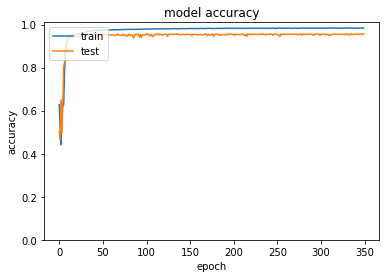

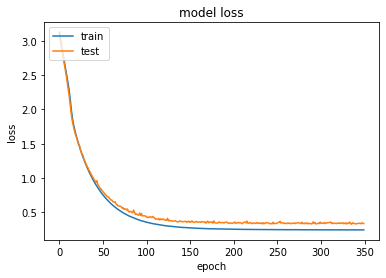

<Figure size 432x288 with 0 Axes>

In [87]:
plt.plot(cnn2d_history.history['acc'])
plt.plot(cnn2d_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.ylim([0,1.01])
plt.show()
plt.savefig('AccEpoch24_2.png')
plt.plot(cnn2d_history.history['loss'])
plt.plot(cnn2d_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.savefig('LossEpoch24_2.png')

In [88]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = cnn2d_model.predict(X_val_padded)
y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
print("Precision:", round(precision_score(y_val, y_pred , average="macro"),2))
print("Recall:", round(recall_score(y_val, y_pred, average="macro"),2))
print("F1 Score:", round(f1_score(y_val, y_pred , average="macro"),2))


Precision: 0.43
Recall: 0.5
F1 Score: 0.46


C:\Users\ketak\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* 1 Sentence => 1 Matrix of size : #words x wD
- N sentences => N matrix of above size 
- every sentence has different words of differnt size
- sort the sentences in increasing length of words and truncate the sentences above 95-percentile length

In [156]:
backend.clear_session()

In [22]:
print((X_train))

[' Clear target multiple copies effect inefficiency '
 ' TODO This nd part method ' ' create new empty project' ... ' ok'
 ' TODO returns Collection single Object Is callers expect '
 ' see org argouml cognitive critics Critic toDoItem java lang Object org argouml cognitive Designer ']


In [30]:
X_train.shape

(7561,)

In [23]:
sequences

[[265, 1167]]

In [25]:
matrices.shape #not be 5351, should be median remove empty, 95
#tokenizer hugging face wala use kar, has truncate keyword

(7561, 5351)

In [26]:
len(X_train[0])

50

In [27]:
sorted(X_train, key = lambda x : len(x))[0]

' '

In [14]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                          lower=True)

tokenizer.fit_on_texts(X_train)

In [17]:
sequences = tokenizer.texts_to_sequences(["this perhaps not really necessary"])

In [18]:
sequences

[[14, 918, 320, 152, 514]]

In [19]:
X_train.shape

(7561,)

In [20]:
matrices = tokenizer.texts_to_matrix(X_train)

In [21]:
matrices

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

# Test your prep


In [34]:
corpus = [
    # Positive Reviews

    'This is an excellent movie',
    'The move was fantastic I like it',
    'You should watch it is brilliant',
    'Exceptionally good',
    'Wonderfully directed and executed I like it',
    'Its a fantastic series',
    'Never watched such a brillent movie',
    'It is a Wonderful movie',

    # Negtive Reviews

    "horrible acting",
    'waste of money',
    'pathetic picture',
    'It was very boring',
    'I did not like the movie',
    'The movie was horrible',
    'I will not recommend',
    'The acting is pathetic'
]
sentiments = np.array([1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0])

In [36]:
sentiments = np.array([1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0])

In [45]:
#Embedding Layer (wordVocab,wordDim,inputlen) -- transforms words as rows, dimesions as cols matrx
from nltk.tokenize import word_tokenize

all_words = []
for sent in corpus:
    tokenize_word = word_tokenize(sent)
    #tokenize_word is a list of all words in a sentence
    for word in tokenize_word:
        all_words.append(word)
#all_words
#we only need unique words 
unique_words = set(all_words)
print(len(unique_words))
vocab_length = len(unique_words)

45


In [46]:
from tensorflow.keras.preprocessing.text import one_hot
embedded_sentences = [one_hot(sent, vocab_length) for sent in corpus]
print(embedded_sentences)
#but all these are different lengths so pad them equal to len if longest sentence

[[33, 25, 1, 12, 13], [35, 19, 19, 4, 30, 14, 36], [37, 37, 31, 36, 25, 40], [27, 7], [25, 10, 10, 5, 30, 14, 36], [40, 30, 4, 36], [32, 12, 26, 30, 10, 13], [36, 25, 30, 3, 13], [44, 28], [6, 5, 1], [10, 6], [36, 19, 24, 6], [30, 31, 19, 14, 35, 13], [35, 13, 19, 44], [30, 13, 19, 30], [35, 28, 25, 10]]


In [47]:
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(corpus, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

In [48]:
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
print(padded_sentences)

[[33 25  1 12 13  0  0]
 [35 19 19  4 30 14 36]
 [37 37 31 36 25 40  0]
 [27  7  0  0  0  0  0]
 [25 10 10  5 30 14 36]
 [40 30  4 36  0  0  0]
 [32 12 26 30 10 13  0]
 [36 25 30  3 13  0  0]
 [44 28  0  0  0  0  0]
 [ 6  5  1  0  0  0  0]
 [10  6  0  0  0  0  0]
 [36 19 24  6  0  0  0]
 [30 31 19 14 35 13  0]
 [35 13 19 44  0  0  0]
 [30 13 19 30  0  0  0]
 [35 28 25 10  0  0  0]]


In [83]:
e = Embedding(vocab_length, 20, input_length=length_long_sentence)
e.output_dim #16 * 7* 20

20

In [78]:
from tensorflow.keras import Sequential
model = Sequential()
model.add(Embedding(vocab_length, 20, input_length=length_long_sentence))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [53]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 20)             900       
_________________________________________________________________
flatten (Flatten)            (None, 140)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 141       
Total params: 1,041
Trainable params: 1,041
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
model.fit(padded_sentences, sentiments, epochs=100, verbose=1)

Epoch 1/100
1/1 [==============================] - 0s 0s/step - loss: 0.6940 - acc: 0.4375
Epoch 2/100
1/1 [==============================] - 0s 0s/step - loss: 0.6906 - acc: 0.5000
Epoch 3/100
1/1 [==============================] - 0s 0s/step - loss: 0.6873 - acc: 0.6250
Epoch 4/100
1/1 [==============================] - 0s 0s/step - loss: 0.6839 - acc: 0.6875
Epoch 5/100
1/1 [==============================] - 0s 0s/step - loss: 0.6805 - acc: 0.7500
Epoch 6/100
1/1 [==============================] - 0s 0s/step - loss: 0.6771 - acc: 0.7500
Epoch 7/100
1/1 [==============================] - 0s 0s/step - loss: 0.6738 - acc: 0.8750
Epoch 8/100
1/1 [==============================] - 0s 0s/step - loss: 0.6704 - acc: 0.8750
Epoch 9/100
1/1 [==============================] - 0s 0s/step - loss: 0.6670 - acc: 0.8750
Epoch 10/100
1/1 [==============================] - 0s 0s/step - loss: 0.6637 - acc: 0.8750
Epoch 11/100
1/1 [==============================] - 0s 0s/step - loss: 0.6603 - acc: 0.87

1/1 [==============================] - 0s 8ms/step - loss: 0.3306 - acc: 1.0000
Epoch 91/100
1/1 [==============================] - 0s 0s/step - loss: 0.3264 - acc: 1.0000
Epoch 92/100
1/1 [==============================] - 0s 8ms/step - loss: 0.3222 - acc: 1.0000
Epoch 93/100
1/1 [==============================] - 0s 0s/step - loss: 0.3180 - acc: 1.0000
Epoch 94/100
1/1 [==============================] - 0s 8ms/step - loss: 0.3139 - acc: 1.0000
Epoch 95/100
1/1 [==============================] - 0s 0s/step - loss: 0.3098 - acc: 1.0000
Epoch 96/100
1/1 [==============================] - 0s 0s/step - loss: 0.3057 - acc: 1.0000
Epoch 97/100
1/1 [==============================] - 0s 0s/step - loss: 0.3017 - acc: 1.0000
Epoch 98/100
1/1 [==============================] - 0s 8ms/step - loss: 0.2977 - acc: 1.0000
Epoch 99/100
1/1 [==============================] - 0s 0s/step - loss: 0.2937 - acc: 1.0000
Epoch 100/100
1/1 [==============================] - 0s 0s/step - loss: 0.2897 - acc: 1.0

In [55]:
loss, accuracy = model.evaluate(padded_sentences, sentiments, verbose=0)
print('Accuracy: %f' % (accuracy*100))


Accuracy: 100.000000
